# Medical ChatBot-RAG Based Approach

The project aims to develop a robust Retrieval-Augmented Generation (RAG) based medical chatbot to overcome the limitations observed within the medical domain. Medical chatbots offer instant access to healthcare information, guidance, and support, augmenting healthcare accessibility and efficiency. They provide timely responses to queries, aiding in symptom assessment, medication reminders, and wellness advice. Particularly beneficial in remote areas or during non-office hours, they reduce strain on healthcare systems, offering preliminary assessments and reassurance to users. Additionally, they enhance patient education, promoting proactive healthcare practices and facilitating early intervention for potential health issues. Through continuous learning and adaptation, medical chatbots evolve to meet user needs, fostering a more informed and empowered healthcare experience while alleviating pressure on traditional medical services.


## Notebook Breakdown:

- Importing Required Resources: This step involves identifying and bringing in all necessary tools, and other resources required for the project. This may include programming languages, machine learning frameworks, data collection tools, and any other dependencies.

- Data Gathering and Preparation: In this phase, data relevant to the project is collected, this could include data cleaning, preprocessing, and structuring the data in a format suitable for analysis or modeling.

- Creating a Vector Database using only the contexts: Here, the collected data is transformed into numerical vectors while preserving semantic meaning. This typically involves techniques such as word embedding models or contextual embedding models to represent words or sentences as dense vectors.

- Testing Vector Database: After creating the vector database, it's important to validate its effectiveness. This could involve querying the database with known inputs and verifying that the retrieved vectors match expectations.

- Testing the Vector Database if the same question is paraphrased: This step involves assessing the robustness of the vector database to handle paraphrased queries. It tests whether the database can accurately retrieve relevant vectors even when the query is rephrased or expressed differently.

- Creating Retrieval Augmented Generation (RAG) pipeline using LANGCHAIN: Building upon the vector database, this step involves constructing a pipeline that integrates retrieval and generation techniques using LANGCHAIN.

- Evaluating the RAG pipeline using RAGAS: Once the RAG pipeline is established, it needs to be evaluated for its effectiveness in generating relevant responses to queries. RAGAS (Retrieval Augmented Generation Assessment Suite) could be a standardized evaluation framework or set of metrics used for this evaluation.

- Performance Measures: Various metrics and performance measures are calculated to assess the efficiency and effectiveness of the RAG pipeline. 

- Evaluation Results: Finally, the results of the evaluation are summarized and analyzed. This includes faithfulness", "context_precision", "context_recall", "answer_similarity", "answer_relevancy", "answer_correctness".

## Importing necessary libraries

In [80]:
from datasets import load_dataset # Used to load dataset from Hugging face
from warnings import filterwarnings # Used to filter warnings
from pinecone import Pinecone # Used to create vector database
from sentence_transformers import SentenceTransformer # Used to create dense vector embeddings
import torch # Used for torch operations
from pinecone_text.sparse import SpladeEncoder # Used to create sparse embeddings
import os # Used for OS operations
from tqdm import tqdm # Used for tracking the progress
from langchain.vectorstores import Pinecone as pc # Used for connecting the vectordatabase to the RAG pipeline
from langchain_community.embeddings import SentenceTransformerEmbeddings # Used for converting retrieval queries into dense vector embeddings
from langchain_openai import ChatOpenAI # Used for text generation
from langchain.chains import RetrievalQA # Used for creating a RAG pipeline
import numpy as np # Used for numpy operations
import pandas as pd # Used to create a pandas Dataframe
from datasets import Dataset # Used to create dataset object
import seaborn as sns # Used to visualize RAG evaluation
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall, context_relevancy, answer_similarity, answer_correctness # Used to evaluate RAG pipeline
from ragas import evaluate # Used to evaluate RAG pipeline
import matplotlib.pyplot as plt # Used for visualization
pinecone = Pinecone(api_key = os.environ["PINECONE_API_KEY"]) # Initialising Pinecone object for vector database

filterwarnings("ignore")


## Data Gathering and Preparation

In [4]:
data = load_dataset("pubmed_qa", "pqa_labeled", split = "train") # Loading the dataset from Hugging Face
data

Dataset({
    features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
    num_rows: 1000
})

In [5]:
data[0] # View the data format

{'pubid': 21645374,
 'question': 'Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?',
 'context': {'contexts': ['Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.',
   'The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD (NPCD), ce

In [6]:
data[0]["question"] # View a medical question

'Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?'

In [7]:
data[0]["context"]["contexts"] # View the contexts required to answer the medical question

['Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.',
 'The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD (NPCD), cells in early stages of PCD (EPCD), and cells in late stages of PCD (LPCD). Window stage leaves were stained with the mitochondrial dye MitoTracker Red CMX

In [8]:
data[0]["long_answer"] # View the ground truth answer (Long answer) to the medical question

'Results depicted mitochondrial dynamics in vivo as PCD progresses within the lace plant, and highlight the correlation of this organelle with other organelles during developmental PCD. To the best of our knowledge, this is the first report of mitochondria and chloroplasts moving on transvacuolar strands to form a ring structure surrounding the nucleus during developmental PCD. Also, for the first time, we have shown the feasibility for the use of CsA in a whole plant system. Overall, our findings implicate the mitochondria as playing a critical and early role in developmentally regulated PCD in the lace plant.'

In [9]:
data[0]["final_decision"] # View the short response for a given question

'yes'

In [10]:
text = data[0]["context"]["contexts"] # Creating a random text context for testing the chunker function
text

['Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.',
 'The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD (NPCD), cells in early stages of PCD (EPCD), and cells in late stages of PCD (LPCD). Window stage leaves were stained with the mitochondrial dye MitoTracker Red CMX

In [11]:
limit = 384
def chunker(contexts: list[object]):
    """
    A function to create chunks out of context provided
    Args: Requires a list of contexts
    Returns: Returns a list of contexts within the embedding character limit
    """
    chunks = [] # A list to return all the context
    all_contexts = " ".join(contexts).split(".") # join all the provided context and splitting them based on sentences
    chunk = [] # A list to retrieve each sentence at a time
    for context in all_contexts: # Iterating over each sentence
        chunk.append(context) # Appending each sentence
        # If the length of sentences is greater than 3 or if the character limit has been reached
        if len(chunk) >=3 and len(".".join(chunk))> limit:
            # Appending the chunks list with the few sentences
            chunks.append(".".join(chunk).strip()+".")
            # Add some overlap to the next context/ sentences
            chunk = chunk[-2:]
    # If we complete the loop and still have a chunk left (less than the character limit), add it
    if chunk is not None:
        chunks.append(".".join(chunk))
    return chunks


In [12]:
chunks = chunker(text) # Testing the chunker function
chunks

['Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature.',
 'The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants. The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A.',
 'The role of mitochondria during PCD has been recognized in animals; however, it has been less

In [13]:
ids_context = [] # Creating a list of ids and context
for i in data: # Iterating over every data row
    chunks = chunker(i["context"]["contexts"]) # Chunking contexts into limited number of characters for dense and sparse embeddings
    for x, context in enumerate(chunks): # Iterating over each chunk
        ids_context.append({
            "id" : f"{i['pubid']} - {x}", 
            "context": context
        }) # Append each unique id for a chunk of context

ids_context[:2] # View the created list

[{'id': '21645374 - 0',
  'context': 'Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature.'},
 {'id': '21645374 - 1',
  'context': 'The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants. The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A.'}]

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Consider GPU if available
dense_model = SentenceTransformer("msmarco-bert-base-dot-v5", device = device) # Creating a Transformer model for dense embeddings
dense_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
)

In [15]:
embeds = dense_model.encode(ids_context[0]["context"]) # Creating a test dense embedding 
embeds.shape # View the shape of dense embedding for creating the vector database of the same dimension

(768,)

In [16]:
sparse_model = SpladeEncoder() # Initializing spade for sparse embeddings
sparse_embeds = sparse_model.encode_queries(ids_context[0]["context"]) # Creating a test sparse embedding
sparse_embeds # Visualising a sample sparse embedding

{'indices': [1000,
  1039,
  1052,
  1997,
  1999,
  2003,
  2024,
  2049,
  2083,
  2094,
  2173,
  2239,
  2278,
  2290,
  2306,
  2331,
  2415,
  2427,
  2523,
  2537,
  2550,
  2565,
  2566,
  2597,
  2644,
  2754,
  2757,
  2832,
  2974,
  3030,
  3081,
  3102,
  3252,
  3269,
  3274,
  3280,
  3370,
  3392,
  3399,
  3508,
  3526,
  3571,
  3581,
  3628,
  3727,
  3740,
  3817,
  3965,
  3968,
  4264,
  4295,
  4372,
  4442,
  4456,
  4574,
  4649,
  4717,
  4730,
  4758,
  4775,
  4870,
  4962,
  4963,
  5080,
  5104,
  5258,
  5397,
  5701,
  5708,
  5920,
  5996,
  6198,
  6210,
  6215,
  6310,
  6418,
  6470,
  6531,
  6546,
  6580,
  6897,
  7053,
  7337,
  7366,
  7403,
  7473,
  7609,
  7691,
  7775,
  7816,
  8475,
  8676,
  8715,
  8761,
  8765,
  8872,
  8979,
  9007,
  9232,
  9448,
  9607,
  9706,
  9890,
  9895,
  9915,
  10012,
  10088,
  10244,
  10267,
  10327,
  10507,
  10708,
  10738,
  11503,
  11568,
  11704,
  11767,
  11798,
  11829,
  11934,
  12222,
  124

In [37]:
index = pinecone.Index("medical-chatbot") # Creating an index object for Pinecone vector database having dimension of 768
index

The index should use DOT product in pinecone to consider sparse vectors

## Creating a Vector Database using ***only the contexts***

In [55]:
batch_size = 200 # Batch size for upserts
with tqdm(total = len(ids_context)// batch_size +1) as pbar: # Configuring TQDM for progress
    for i in range(0, len(ids_context), batch_size): # Iterating over a batch of context
        i_end = min(i+batch_size, len(ids_context)) # Create ending index of the batch
        ids = [x["id"] for x in ids_context[i:i_end]] # Create a list of ids for the entire batch
        contexts = [x["context"] for x in ids_context[i:i_end]] # Create a list of contexts for the entire batch 
        sparse_embeds = sparse_model.encode_queries(contexts) # Create sparse embeddings for the entire batch of contexts
        dense_embeds = dense_model.encode(contexts) # Create Dense embeddings for the entire batch of contexts
        upserts = [] # Create a list to upsert embeddings into vector database
        for _id, _context, _sparse, _dense in zip(ids, contexts, sparse_embeds, dense_embeds): # Iterating over each batch
            upserts.append({
                "id":_id,
                "values": _dense,
                "sparse_values": _sparse,
                "metadata": {"context":_context}
            }) # Generating the batch required for upserts
        index.upsert(upserts) # Adding each batch to the vector database at a time
        pbar.update(1) # Updating the progress bar
        
index.describe_index_stats() # Checking the index status

100%|██████████| 30/30 [16:44<00:00, 33.49s/it]


{'dimension': 768,
 'index_fullness': 0.058,
 'namespaces': {'': {'vector_count': 5800}},
 'total_vector_count': 5800}

## Testing the Vector Database

In [18]:
id = 711 # Configure a data id for testing vector database
print(f"Question: {data[id]['question']}") # Print the medical question for testing the retrieval component
print(f"Pubmed Question ID: {data[id]['pubid']}") # Print the medical question id
vector = dense_model.encode(data[id]["question"]).tolist() # Create the vector embeddings of the search query (MEDICAL QUESTION)
sparse_vector = sparse_model.encode_queries(data[id]["question"]) # Create the sparse embedding of the seach query (MEDICAL QUESTION)
result = index.query(
    top_k = 5,
    vector = vector,
    sparse_vector= sparse_vector,
    include_metadata=True
) # Searching the query for top k results in the vector database
result # Print the results from vector database

Question: Can clinicians use the PHQ-9 to assess depression in people with vision loss?
Pubmed Question ID: 19156007


{'matches': [{'id': '19156007 - 0',
              'metadata': {'context': 'To investigate whether the Patient '
                                      'Health Questionnaire-9 (PHQ-9) '
                                      'possesses the essential psychometric '
                                      'characteristics to measure depressive '
                                      'symptoms in people with visual '
                                      'impairment. The PHQ-9 scale was '
                                      'completed by 103 participants with low '
                                      'vision. These data were then assessed '
                                      'for fit to the Rasch model. The '
                                      "participants' mean +/- standard "
                                      'deviation (SD) age was 74.7 +/- 12.2 '
                                      'years.'},
              'score': 203.634186,
              'values': []},
             {'id'

## Testing the Vector Database if the same question is paraphrased

In [19]:
query = "For humans with loss of eye-sight, can we depression be assessed by leveraging PHQ-9" # Paraphrasing the previous question to retrieve same results
print("Question: ", query) # Print the paraphrased question
vector = dense_model.encode(query).tolist() # Create vector embeddings of the search query (MEDICAL QUESTION)
sparse_vector = sparse_model.encode_queries(query) # Create sparse embeddings of the search query (MEDICAL QUESTION)

result = index.query(
    top_k = 5,
    vector = vector,
    sparse_vector= sparse_vector,
    include_metadata=True
) # Searching the query for top k results in the vector database
result # Print the results from vector database

Question:  For humans with loss of eye-sight, can we depression be assessed by leveraging PHQ-9


{'matches': [{'id': '19156007 - 0',
              'metadata': {'context': 'To investigate whether the Patient '
                                      'Health Questionnaire-9 (PHQ-9) '
                                      'possesses the essential psychometric '
                                      'characteristics to measure depressive '
                                      'symptoms in people with visual '
                                      'impairment. The PHQ-9 scale was '
                                      'completed by 103 participants with low '
                                      'vision. These data were then assessed '
                                      'for fit to the Rasch model. The '
                                      "participants' mean +/- standard "
                                      'deviation (SD) age was 74.7 +/- 12.2 '
                                      'years.'},
              'score': 204.999908,
              'values': []},
             {'id'

## Creating **Retrieval augmented Generation (RAG)** pipeline using LANGCHAIN

In [20]:
embeddings = SentenceTransformerEmbeddings(model_name="msmarco-bert-base-dot-v5") # Creating a langchain's Sentence Transformer embedding function for the same transformer model

In [38]:
db = pc(index = index, 
        embedding = embeddings,
        text_key = "context") # Creating a Pinecone vector database object for the same vector database using Langchain

In [39]:
db.similarity_search(query, k = 5) # Searching the same query (MEDICAL QUESTION)

[Document(page_content="To investigate whether the Patient Health Questionnaire-9 (PHQ-9) possesses the essential psychometric characteristics to measure depressive symptoms in people with visual impairment. The PHQ-9 scale was completed by 103 participants with low vision. These data were then assessed for fit to the Rasch model. The participants' mean +/- standard deviation (SD) age was 74.7 +/- 12.2 years."),
 Document(page_content='Findings from the Sequenced Treatments Alternatives to Relieve Depression (STAR*D) emphasized the importance of measurement-based care for the treatment of depression as a key ingredient for achieving response and remission; yet measurement-based care approaches are not commonly used in clinical practice. The Nine-Item Patient Health Questionnaire (PHQ-9) for monitoring depression severity was introduced in 19 diverse psychiatric practices. During the one-year course of the project the helpfulness and feasibility of implementation of PHQ-9 in these psych

In [32]:
llm = ChatOpenAI(temperature = 0, model = "gpt-3.5-turbo") # Creating a LLM object for RAG pipeline
qa = RetrievalQA.from_chain_type(llm = llm, chain_type= "stuff", retriever = db.as_retriever()) # Generating RAG pipeline

In [33]:
result = qa.invoke(query) # Searching the same query (MEDICAL QUESTION)
result # Print the results from RAG pipeline

{'query': 'For humans with loss of eye-sight, can we depression be assessed by leveraging PHQ-9',
 'result': 'Yes, the Patient Health Questionnaire-9 (PHQ-9) has been used to assess depressive symptoms in people with visual impairment. The study mentioned in the context assessed the fit of PHQ-9 data to the Rasch model in participants with low vision, confirming its construct validity and reliability in this population.'}

In [34]:
print(f"Question: {query}") # Print the paraphased medical question
print(f"Original Question: {data[id]['question']}") # Print the original question
print(f"Ground Truth answer: {data[id]['long_answer']}") # Print the Ground truth answer from the original dataset
print(f"Predicted Result: {result['result']}") # Print the answer generated from the RAG pipeline

Question: For humans with loss of eye-sight, can we depression be assessed by leveraging PHQ-9
Original Question: Can clinicians use the PHQ-9 to assess depression in people with vision loss?
Ground Truth answer: Our findings demonstrate that the PHQ-9, when scaled with Rasch analysis, forms a linear interval measurement of depressive symptoms suitable for use in a vision impaired population.
Predicted Result: Yes, the Patient Health Questionnaire-9 (PHQ-9) has been used to assess depressive symptoms in people with visual impairment. The study mentioned in the context assessed the fit of PHQ-9 data to the Rasch model in participants with low vision, confirming its construct validity and reliability in this population.


## Evaluating the RAG pipeline using **RAGAS**

In [61]:
eval_data = [] # Creating a list of ids, Medical Questions, List of Retrieved Contexts, Ground Truth answers and the predicted response from LLM
for i in range(10): # Iterating for 10 test records
    id = np.random.randint(0,1000) # Creating a random id for medical question
    eval_data.append({
       "id": data[id]["pubid"],
       "question" : data[id]["question"],
       "contexts": [x.page_content for x in db.similarity_search(data[id]["question"], k = 5)],
       "ground_truth": data[id]["long_answer"],
       "answer" : qa.invoke(data[id]["question"])["result"] 
    }) # Generating the required list for evaluation
eval_data = pd.json_normalize(eval_data) # Creating a dataframe for evaluation
eval_data # View the evaluation dataframe

,id,question,contexts,ground_truth,answer
0,21881325,Do preoperative statins reduce atrial fibrilla...,[Recent studies have demonstrated that statins...,Our study indicated that preoperative statin t...,"Yes, recent studies have shown that preoperati..."
1,22656647,Are acceptance rates of a national preventive ...,[Information on preventive home visit acceptan...,High socioeconomic status was associated with ...,"Yes, the acceptance rates of a national preven..."
2,24939676,Does ultrasound-scored synovitis depend on the...,[The aim of this study was to investigate the ...,Our results suggested that s.c. anti-TNF pharm...,"Yes, the study aimed to investigate the influe..."
3,26965932,Is Bare-Metal Stent Implantation Still Justifi...,[This study sought to investigate the ischemic...,Among HBR patients with stable or unstable cor...,The study mentioned in the context does compar...
4,9920954,"Do ""America's Best Hospitals"" perform better f...","[""America's Best Hospitals,"" an influential li...",Admission to a hospital ranked high on the lis...,"Based on the information provided, it appears ..."
5,25228241,Elephant trunk in a small-calibre true lumen f...,[The elephant trunk technique for aortic disse...,A folded elephant trunk in a small-calibre lum...,The cause of haemolytic anaemia in the case of...
6,19302863,Is the use of cyanoacrylate in intestinal anas...,[Intestinal anastomosis was performed by polyg...,"Better healing, shorter AT, and equal strength...","Based on the provided context, the study compa..."
7,21880023,Does exercise during pregnancy prevent postnat...,[To study whether exercise during pregnancy re...,We did not find a lower prevalence of high EPD...,"Based on the provided context, the study condu..."
8,10811329,Are 99mTc leukocyte scintigraphy and SBFT stud...,[The goal of this retrospective study was to a...,Our results suggest that 99mTc-WBC is useful a...,"Based on the information provided, it appears ..."
9,23052500,Staging laparoscopy in patients with hepatocel...,[Staging laparoscopy (SL) is not regularly per...,"The overall yield of SL for HCC was 7 %, and t...","Based on the provided context, staging laparos..."


In [62]:
eval_data["question"][0] # Print the first question

'Do preoperative statins reduce atrial fibrillation after coronary artery bypass grafting?'

In [63]:
eval_data["contexts"][0] # Print the list of retrieved contexts for the first medical question

['Recent studies have demonstrated that statins have pleiotropic effects, including anti-inflammatory effects and atrial fibrillation (AF) preventive effects. The objective of this study was to assess the efficacy of preoperative statin therapy in preventing AF after coronary artery bypass grafting (CABG). 221 patients underwent CABG in our hospital from 2004 to 2007. 14 patients with preoperative AF and 4 patients with concomitant valve surgery were excluded from this study.',
 '221 patients underwent CABG in our hospital from 2004 to 2007. 14 patients with preoperative AF and 4 patients with concomitant valve surgery were excluded from this study. Patients were divided into two groups to examine the influence of statins: those with preoperative statin therapy (Statin group, n = 77) and those without it (Non-statin group, n = 126). In addition, patients were divided into two groups to determine the independent predictors for postoperative AF: those with postoperative AF (AF group, n =

In [64]:
eval_data["ground_truth"][0] # Print the ground truth answer

'Our study indicated that preoperative statin therapy seems to reduce AF development after CABG.'

In [65]:
eval_data["answer"][0] # Print the Predicted response from RAG pipeline

'Yes, recent studies have shown that preoperative statin therapy may reduce the incidence of atrial fibrillation after coronary artery bypass grafting (CABG). In the study mentioned, patients who received preoperative statin therapy had a lower incidence of postoperative AF compared to those who did not receive statins.'

## Retrieval Metrics

Retrieval is the first step in a RAG pipeline, so we will focus on metrics that assess retrieval first. For that we primarily want to focus on `context_recall` and `context_precision` but before diving into these metrics we must understand what it is that they will be measuring.

### Actual vs. Predicted

When evaluating the performance of retrieval systems we tend to compare the _actual_ (ground truth) to _predicted_ results. We define these as:

* **Actual condition** is the true label of every context in the dataset. These are _positive_ ($p$) if the context is relevant to our query or _negative_ ($n$) if the context is _ir_relevant to our query.

* **Predicted condition** is the _predicted_ label determined by our retrieval system. If a context is returned it is a predicted _positive_, ie $\hat{p}$. If a context is not returned it is a predicted _negative_, ie $\hat{n}$.

Given these conditions, we can say the following:

* $p\hat{p}$ is a **true positive**, meaning a relevant result has been returned.
* $n\hat{n}$ is a **true negative**, meaning an irrelevant result was not returned
* $n\hat{p}$ is a **false positive**, meaning an irrelevant result has been returned.
* $p\hat{n}$ is a **false negative**, meaning an relevant result has _not_ been returned.

Let's see how these apply to our metrics in RAGAS.

#### Context Recall
Context recall (or just _recall_) is a measure of how many of the relevant records in a dataset have been retrieved. It is calculated as:

$$
Recall@K = \frac{p\hat{p}}{p\hat{p} + n\hat{n}} = \frac{Relevant \: contexts \: retrieved}{Total \: number \: of \: relevant \: contexts}
$$

RAGAS calculates _Recall@K_ for recall, where the _@K_ represents the number of contexts returned. As the @K value is increased the recall scores will improve (as the capture size of the retrieval step increases). At it's extreme we could set @K equal to the size of the dataset to guarantee perfect recall — although this negates the point of RAG in the first place.

By default, RAGAS uses a _@K_ value of `5`.

### Context Precision 

Context precision (or just _precision_) is another popular retrieval metric. We typically see both recall and precision paired together when evaluating retrieval systems.

As with recall, the actual metric here is called _Precision@K_ where @K represents the number of contexts returned. However, unlike recall, precision is focusing on the number of relevant results returned compared to the total results returned, whether they are relevant or not — this is equal to our chosen _@K_ value.

$$
Precision@K = \frac{p\hat{p}}{p\hat{p} + p\hat{n}} = \frac{Relevant \: contexts \: retrieved}{Total \: number \: of \: relevant \: contexts}

## Generation Metrics

### Faithfullness

The _faithfullness_ metric measures (from _0_ to _1_) the factual consistency of an answer when compared to the retrieved context. A score of _1_ means all claims in the answer can be found in the context. A score of _0_ would indicate _no_ claims in the answer are found in the context.

We calculate the faithfullness like so:

$$
Faithfulness = \frac{Number \: of \: claims \: in \: answer \: also \: found \: in \: context}{Number \: of \: claims \: in \: answer}
$$

### Answer Relevancy

Answer relevancy is our final metric. It focuses on the generation component and is similar to our "context precision" metric in that it measures how much of the returned information is relevant to our original question.

We return a low answer relevancy score when:

* Answers are incomplete.

* Answers contain redundant information.

A high answer relevancy score indicates that an answer is concise and does not contain "fluff" (ie irrelevant information).

The score is calculated by asking an LLM to generate multiple questions for a generated answer and then calculating the cosine similarity between the original question and the generated questions. Naturally, if we have a concise answer that answers a very specific question, we should find that the generated question will have a high cosine similarity to the original question.

In [66]:
ragas_eval = Dataset.from_dict(eval_data) # Generating a dataset object for RAG evaluation
result = evaluate(
    dataset=ragas_eval,
    metrics=[
        faithfulness,
        answer_relevancy,
        context_precision,
        context_relevancy,
        context_recall,
        answer_similarity,
        answer_correctness,
    ],
)
result = result.to_pandas() # Converting the results into Pandas dataframe

Evaluating: 100%|██████████| 70/70 [01:12<00:00,  1.04s/it]


In [67]:
result # View the results dataframe

,id,question,contexts,ground_truth,answer,faithfulness,answer_relevancy,context_precision,context_relevancy,context_recall,answer_similarity,answer_correctness
0,21881325,Do preoperative statins reduce atrial fibrilla...,[Recent studies have demonstrated that statins...,Our study indicated that preoperative statin t...,"Yes, recent studies have shown that preoperati...",1.000000,0.946651,0.950000,0.235294,1.0,0.946913,0.665300
1,22656647,Are acceptance rates of a national preventive ...,[Information on preventive home visit acceptan...,High socioeconomic status was associated with ...,"Yes, the acceptance rates of a national preven...",1.000000,0.935775,1.000000,0.235294,1.0,0.945586,0.836396
2,24939676,Does ultrasound-scored synovitis depend on the...,[The aim of this study was to investigate the ...,Our results suggested that s.c. anti-TNF pharm...,"Yes, the study aimed to investigate the influe...",0.666667,0.765462,1.000000,0.000000,1.0,0.892874,0.823219
3,26965932,Is Bare-Metal Stent Implantation Still Justifi...,[This study sought to investigate the ischemic...,Among HBR patients with stable or unstable cor...,The study mentioned in the context does compar...,1.000000,0.746774,1.000000,0.000000,1.0,0.923360,0.730840
4,9920954,"Do ""America's Best Hospitals"" perform better f...","[""America's Best Hospitals,"" an influential li...",Admission to a hospital ranked high on the lis...,"Based on the information provided, it appears ...",1.000000,0.904950,1.000000,0.571429,1.0,0.942434,0.535608
5,25228241,Elephant trunk in a small-calibre true lumen f...,[The elephant trunk technique for aortic disse...,A folded elephant trunk in a small-calibre lum...,The cause of haemolytic anaemia in the case of...,0.500000,0.979047,1.000000,0.200000,0.5,0.941417,0.610354
6,19302863,Is the use of cyanoacrylate in intestinal anas...,[Intestinal anastomosis was performed by polyg...,"Better healing, shorter AT, and equal strength...","Based on the provided context, the study compa...",0.333333,0.000000,1.000000,0.000000,1.0,0.936304,0.234080
7,21880023,Does exercise during pregnancy prevent postnat...,[To study whether exercise during pregnancy re...,We did not find a lower prevalence of high EPD...,"Based on the provided context, the study condu...",1.000000,0.932583,0.887500,0.000000,1.0,0.941375,0.835344
8,10811329,Are 99mTc leukocyte scintigraphy and SBFT stud...,[The goal of this retrospective study was to a...,Our results suggest that 99mTc-WBC is useful a...,"Based on the information provided, it appears ...",1.000000,0.920607,1.000000,0.312500,1.0,0.911089,0.870621
9,23052500,Staging laparoscopy in patients with hepatocel...,[Staging laparoscopy (SL) is not regularly per...,"The overall yield of SL for HCC was 7 %, and t...","Based on the provided context, staging laparos...",1.000000,0.967925,0.833333,0.150000,1.0,0.892055,0.785514


## Evaluation Results

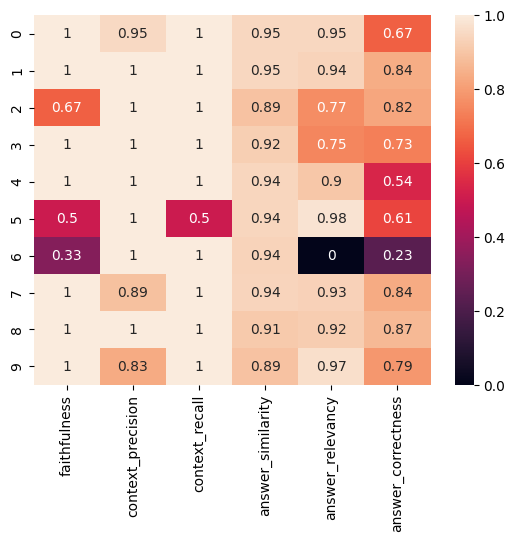

In [81]:
sns.heatmap(result[["faithfulness", "context_precision", "context_recall", "answer_similarity", "answer_relevancy", "answer_correctness"]], annot = True) # Visualizing the results
plt.show()